In [81]:
import numpy as np
from base_notebook.pose_data_tools.graph import Graph
from base_notebook.pose_data_tools.generate_data import read_xyz
from src.preprocessing.pre_normaliser import preNormaliser
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import os
import pandas as pd
import pickle
import iisignature
from tqdm import tqdm

In [3]:
AXES = 0, 2

In [4]:
data = np.load(open("_input/train_data.npy", 'rb'))

In [5]:
labels = pd.read_csv('_input/train_label.csv')
idx = labels[labels['label'].isin([0, 75])].index

In [6]:
N_SAMPLES = 100
N_CLASSES = 100
NOISE = 10.

ps = np.zeros((0, 3, 1, 17, 2))

for i in range(N_CLASSES):
    p1 = data[100*i:100*i+1, :, :1, :, :]
    zs = NOISE * np.random.standard_normal((N_SAMPLES, 3, 1, 17, 2)) + p1
    ps = np.concatenate([ps, zs], axis=0)

X = ps
y = np.arange(N_CLASSES).repeat(N_SAMPLES)

In [7]:
idx = np.arange(N_SAMPLES*N_CLASSES)
np.random.shuffle(idx)
X = X[idx]
y = y[idx].reshape((-1, 1))

In [8]:
from keras.layers import Layer, Dense
import tensorflow as tf
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import special_math_ops

graph = Graph()
mat = graph.get_adjacency_matrix().astype(np.float32)

class GraphAttention(Layer):
    
    def build(self, input_shape):
        output_shape = 50
        self.kernel = self.add_weight('kernel', (input_shape[3], input_shape[4], output_shape), trainable=True)
        self.attention_mask = self.add_weight('attention_mask', mat[0].shape, trainable=True)
        
    def call(self, inputs):
        f0 = tf.einsum('ijklm,lmn->ikln', inputs, self.kernel)
        att = gen_math_ops.Mul(x=mat[0]+mat[1]+mat[2], y=self.attention_mask)
        att = tf.nn.softmax(att)
        return tf.einsum('ml,ikln->ikn', att, f0)

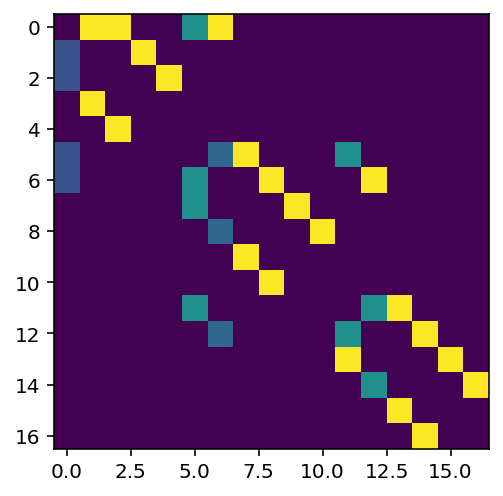

In [169]:
plt.imshow(mat[1] + mat[2])

In [161]:
K.conv2d?

Signature:
K.conv2d(
    x,
    kernel,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
)
Docstring:
2D convolution.

Args:
    x: Tensor or variable.
    kernel: kernel tensor.
    strides: strides tuple.
    padding: string, `"same"` or `"valid"`.
    data_format: `"channels_last"` or `"channels_first"`.
    dilation_rate: tuple of 2 integers.

Returns:
    A tensor, result of 2D convolution.

Raises:
    ValueError: if `data_format` is neither `channels_last` or
    `channels_first`.
File:      /usr/local/lib/python3.9/site-packages/keras/backend.py
Type:      function


In [158]:
image = tf.zeros([10,10,3])
tf.expand_dims(image, axis=0).shape

TensorShape([1, 10, 10, 3])

In [98]:
from keras.layers import Layer, Dense
import tensorflow as tf
from tensorflow.python.framework import tensor_shape

graph = Graph()
mat = graph.get_adjacency_matrix().astype(np.float32)

class GraphAttention(Layer):
    
    def build(self, input_shape):
        hidden_units = 20
        self.kernel = self.add_weight('kernel', (input_shape[3], input_shape[4], hidden_units), trainable=True)
        self.attention_mask = self.add_weight('attention_mask', mat[0].shape, trainable=True)
        
    def call(self, inputs):
        f0 = tf.einsum('ijklm,lmn->ikln', inputs, self.kernel)
        att = tf.einsum('ij,jk', mat[0]+mat[1]+mat[2], self.attention_mask)
        att = tf.nn.softmax(att)
        return tf.einsum('ml,ijklo,lon->ikn', att, inputs, self.kernel)


In [99]:
model.summary()

Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 3, 601, 17, 2)]   0         
_________________________________________________________________
graph_attention_55 (GraphAtt (None, 601, 20)           969       
_________________________________________________________________
lambda_41 (Lambda)           (None, 4, 210)            0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 4, 210)            840       
_________________________________________________________________
lstm_35 (LSTM)               (None, 4, 64)             70400     
_________________________________________________________________
dropout_34 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 256)               0  

In [119]:
model.summary()

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 3, 1, 17, 2)]     0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 1, 17, 100)     300       
_________________________________________________________________
lambda_57 (Lambda)           (None, 4, 210)            0         
_________________________________________________________________
flatten_59 (Flatten)         (None, 840)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 155)               130355    
Total params: 130,655
Trainable params: 130,655
Non-trainable params: 0
_________________________________________________________________


In [ ]:
logsiglen = iisignature.logsiglength(20, 2)

N_TIMESTEPS = 100
N_SEGMENTS = 24
N_HIDDEN_GCN = 20

input_layer = Input(shape=(3, N_TIMESTEPS, 17, 2))
reshape_layer = Reshape()(input_layer)
gcn_layer = Conv1D(20, 1)(reshape_layer)
hidden_layer = Lambda(CLF, arguments=dict(number_of_segment=N_SEGMENTS, deg_of_logsig=2, logsiglen=logsiglen), output_shape=(N_SEGMENTS, logsiglen))(gcn_layer)
BN_layer = BatchNormalization()(hidden_layer)
flatten_layer = Flatten()(BN_layer)
output_layer = Dense(155, activation='softmax')(flatten_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X[:, :, :N_SAMPLES, :, :], to_categorical(y), epochs=20, verbose=2, validation_split=0.15)


In [140]:
from keras import Model, Sequential
from keras.layers import Flatten, BatchNormalization, Reshape, Dropout, Lambda, LSTM, Input, Conv2D, Conv1D, concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from src.algos.logsigrnn.sigutils import *
from src.algos.logsigrnn.dyadic_sigutils import *
import tensorflow as tf
from base_notebook.pose_data_tools.graph import Graph
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam


graph = Graph()
mat = graph.get_adjacency_matrix().astype(np.float32)

class GraphAttention(Layer):
    
    def __init__(self, n_hidden_units ,**kwargs):
        super(GraphAttention, self).__init__(**kwargs)
        self.n_hidden_units = n_hidden_units
    
    def build(self, input_shape):
        self.kernel = self.add_weight('kernel', (input_shape[3], input_shape[4], self.n_hidden_units), trainable=True)
        self.attention_mask = self.add_weight('attention_mask', mat[0].shape, trainable=True)
        
    @tf.function
    def call(self, inputs):
        f0 = tf.einsum('ijklm,lmn->ikln', inputs, self.kernel)
        att = tf.einsum('ij,ij->ij', mat[0]+mat[1]+mat[2], self.attention_mask)
        att = tf.nn.softmax(att)
        return tf.einsum('ml,ijklo,lon->ikn', att, inputs, self.kernel)


X = data[:, :, :, :, :]
y = labels['label']

N_SEGMENTS = 4
N_HIDDEN_UNITS = 20

logsiglen = iisignature.logsiglength(N_HIDDEN_UNITS, 2)

input_layer = Input(shape=X.shape[1:])
gcn_layer = GraphAttention(N_HIDDEN_UNITS)(input_layer)

mid_output = Lambda(SP, arguments=dict(no_of_segments=N_SEGMENTS), output_shape=(N_SEGMENTS, N_HIDDEN_UNITS))(gcn_layer)
hidden_layer = Lambda(CLF, arguments=dict(number_of_segment=N_SEGMENTS, deg_of_logsig=2, logsiglen=logsiglen), output_shape=(N_SEGMENTS, logsiglen))(gcn_layer)
hidden_layer = Reshape((N_SEGMENTS, logsiglen))(hidden_layer)
BN_layer = BatchNormalization()(hidden_layer)

mid_input = concatenate([mid_output, BN_layer])
lstm_layer = LSTM(units=64, return_sequences=True)(mid_input)
drop_layer = Dropout(0.8)(lstm_layer)
upper_mid_input = Flatten()(drop_layer)
output_layer = Dense(155, activation='softmax')(upper_mid_input)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, to_categorical(y), epochs=20, verbose=2, validation_split=0.15)


Epoch 1/20


KeyboardInterrupt: 

In [91]:
def visualize(data):

    N, C, T, V, M = data.shape

    x0, x1 = np.min(data[:, AXES[0], :, :, :]), np.max(data[:, AXES[0], :, :, :])
    y0, y1 = np.min(data[:, AXES[1], :, :, :]), np.max(data[:, AXES[1], :, :, :])

    ratio = (y1 - y0) / (x1 - x0)

    size = 3
    
    xh = size
    yh = ratio * size

    graph = Graph()
    fig, ax = plt.subplots(figsize=(xh, yh))

    plt.xlim((x0, x1))
    plt.ylim((y0, y1))

    edge = graph.inward

    p_type = ['b-', 'g-', 'g-', 'c-', 'm-', 'y-', 'k-', 'k-', 'k-', 'k-']
    pose = []

    for m in range(M):
        a = []
        for i in range(len(edge)):
            a.append(ax.plot(np.zeros(2), np.zeros(2), p_type[m])[0])
        pose.append(a)

    def animate(t):

        for m in range(M):

            for i, (v1, v2) in enumerate(edge):
                x1 = data[0, AXES, t, v1, m]
                x2 = data[0, AXES, t, v2, m]
                if (x1.sum() != 0 and x2.sum() != 0) or v1 == 1 or v2 == 1:
                    pose[m][i].set_xdata(data[0, AXES[0], t, [v1, v2], m])
                    pose[m][i].set_ydata(data[0, AXES[1], t, [v1, v2], m])

        return np.array(pose).flatten()

    anim = animation.FuncAnimation(fig, animate, frames=T, interval=20, blit=True)
    return HTML(anim.to_html5_video())